# Sheet 5

In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

%matplotlib inline
plt.rcParams['font.size'] = 9
plt.rcParams['figure.figsize'] = (12 / 2.54, 6 / 2.54)
plt.rcParams['figure.constrained_layout.use'] = True

## The logistic sigmoid

### (a)

$$
\sigma(x) = \frac{1}{1 + e^{-x}} = 1 - \frac{e^{-x}}{1 + e^{-x}}
$$

$$
\sigma'(x) = \frac{e^{-x}}{(1 + e^{-x})^2} = \sigma(x) \, \frac{e^{-x}}{1 + e^{-x}} = \sigma(x) \, (1 - \sigma(x))
$$

### (b)

$$ \begin{aligned}
    \tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}} &= \frac{1 - e^{-2x}}{1 + e^{-2x}} \\
    &= \frac{1}{1 + e^{-2x}} - \frac{e^{-2x}}{1 + e^{-2x}} \\
    &= \frac{1}{1 + e^{-2x}} - \left(1 - \frac{1}{1 + e^{-2x}}\right) = 2 \, \sigma(2x) - 1
\end{aligned} $$

### (c)

Geometrically, we want a diagonal decision boundary between the `o`'s and `x`'s:

```plain
    y
    ^
  3 |         o ⟋
    |         ⟋
  2 |     o ⟋ x
    |     ⟋
  1 |   ⟋ x
0.5 | ⟋
  0 |
    • — — — — — — — > x
      0   1   2   3
```

That line (the decision boundary) would be $y = x + 0.5$, which can be written as

$$ x - y + 0.5 = 0 \quad \Longrightarrow \quad {\rm\bf w} = (1, -1),\ \ b = 0.5 $$

## Logistic regression: an LLM lie detector

Download the data from https://heibox.uni-heidelberg.de/f/38bd3f2a9b7944248cc2/   
Unzip it and place the lie_detection folder in the folder named `data` to get the following structure:
"data/lie_detection/datasets" and "data/lie_detection/acts".

This is how you can load a dataset of LLM activations. Use a new Datamanager if you want to have a new dataset. Use the same data manager if you want to combine datasets.

In [ ]:
from lie_detection_utils import DataManager

path_to_datasets = "data/lie_detection/datasets"
path_to_acts = "data/lie_detection/acts"

# check if the datasets and activations are available
assert os.path.exists(path_to_datasets), "The path to the datasets does not exist."
assert os.path.exists(path_to_acts), "The path to the activations does not exist."

# these are the different datasets containing true and false factual statements about different topics
dataset_names = ["cities", "neg_cities", "sp_en_trans", "neg_sp_en_trans"]
dataset_name = dataset_names[0] # choose some dataset from the above datasets, index "0" loads the "cities" dataset for example

# the dataloader automatically loads the training data for us
dm = DataManager()
dm.add_dataset(dataset_name, "Llama3", "8B", "chat", layer=12, split=0.8, center=False,
               device='cpu', path_to_datasets=path_to_datasets, path_to_acts=path_to_acts)

acts_train, labels_train = dm.get('train') # train set
acts_test, labels_test = dm.get('val') # validation set
print(acts_train.shape, labels_train.shape)

torch.Size([1196, 4096]) torch.Size([1196])


### (a)

In [ ]:
for dataset_name in dataset_names:
    dm = DataManager()
    dm.add_dataset(dataset_name, "Llama3", "8B", "chat", layer=12, split=0.8, center=False,
                   device='cpu', path_to_datasets=path_to_datasets, path_to_acts=path_to_acts)
    
    acts_train, labels_train = dm.get('train')
    acts_test, labels_test = dm.get('val')
    
    # train without regularization
    classifier = LogisticRegression(penalty=None)
    classifier.fit(acts_train, labels_train)
    
    score = classifier.score(acts_test, labels_test)
    print(f"score for {dataset_name} classifier: {score:.4f}")

score for cities classifier: 1.0000
score for neg_cities classifier: 1.0000
score for sp_en_trans classifier: 1.0000
score for neg_sp_en_trans classifier: 1.0000


As all classifiers get a 100% correctness score on their respective dataset, we can assume that the activation vectors are linearly separable.

### (b)

In [ ]:
classifier_no_reg = LogisticRegression(penalty=None)
classifier_reg = LogisticRegression(penalty="l2")

# train with "cities" dataset
dm = DataManager()
dm.add_dataset(dataset_names[0], "Llama3", "8B", "chat", layer=12, split=0.8, center=False,
               device='cpu', path_to_datasets=path_to_datasets, path_to_acts=path_to_acts)

for classifier in (classifier_no_reg, classifier_reg):
    classifier.fit(*dm.get('train'))

# validate with other datasets
for dataset_name in dataset_names[1:]:
    dm = DataManager()
    dm.add_dataset(dataset_name, "Llama3", "8B", "chat", layer=12, split=0.8, center=False,
                   device='cpu', path_to_datasets=path_to_datasets, path_to_acts=path_to_acts)

    score_no_reg = classifier_no_reg.score(*dm.get("val"))
    score_reg = classifier_reg.score(*dm.get("val"))

    print(f"score for {dataset_name} without regularization: {score_no_reg:.2f}")
    print(f"score for {dataset_name} with regularization: {score_reg:.2f}")

score for neg_cities without regularization: 0.48
score for neg_cities with regularization: 0.48
score for sp_en_trans without regularization: 0.79
score for sp_en_trans with regularization: 1.00
score for neg_sp_en_trans without regularization: 0.45
score for neg_sp_en_trans with regularization: 0.45


The classifier does generalize over topics, though regularization is necessary for a similar 100% score. However, it does not generalize over statements with and without negation. The score of ~50% basically just means randomly guessed.

### (c)

In [29]:
classifier = LogisticRegression(penalty="l2")

# train with negated and non-negated "cities" dataset
dm = DataManager()
dm.add_dataset(dataset_names[0], "Llama3", "8B", "chat", layer=12, split=0.8, center=False,
               device='cpu', path_to_datasets=path_to_datasets, path_to_acts=path_to_acts)
dm.add_dataset(dataset_names[1], "Llama3", "8B", "chat", layer=12, split=0.8, center=False,
               device='cpu', path_to_datasets=path_to_datasets, path_to_acts=path_to_acts)

classifier.fit(*dm.get('train'))

# validate with spanish translation
dm = DataManager()
dm.add_dataset(dataset_names[2], "Llama3", "8B", "chat", layer=12, split=0.8, center=False,
               device='cpu', path_to_datasets=path_to_datasets, path_to_acts=path_to_acts)
dm.add_dataset(dataset_names[3], "Llama3", "8B", "chat", layer=12, split=0.8, center=False,
               device='cpu', path_to_datasets=path_to_datasets, path_to_acts=path_to_acts)

score = classifier.score(*dm.get('val'))
print(f"score with both negated and affirmative statements: {score:.4f}")

score with both negated and affirmative statements: 0.9789


It seems to be possible to train a classifier that works for both kinds of statements. However, the activation vectors for negated and affirmative statements are not linearly separable, thus we won't get a 100% score.

## Log-sum-exp and soft(arg)max

### (a)

#### (i) Constant offset

$$ \begin{aligned}
\mathrm{softmax}(\mathbf\sigma + \mathbf\delta; \lambda)_k
    &= \frac{\exp(\lambda \sigma_k + \lambda \delta)}{\sum_{j=1}^K \exp(\lambda\sigma_j + \lambda\delta)} \\
    &= \frac{\exp(\lambda\sigma_k)\,\cancel{\exp(\lambda\delta)}}{\sum_{j=1}^K \exp(\lambda\sigma_j)\,\cancel{\exp(\lambda\delta)}} = \mathrm{softmax}(\mathbf\sigma; \lambda)_k
\end{aligned} $$

#### (ii) Rescaling

$$ \begin{aligned}
\mathrm{softmax}(\alpha \mathbf\sigma; \lambda)_k
    &= \frac{\exp(\alpha \lambda \sigma_k)}{\sum_{j=1}^K \exp(\alpha \lambda \sigma_j)} = \mathrm{softmax}(\mathbf\sigma; \alpha\lambda)_k
\end{aligned} $$

The soft(arg)max function is invariant under a constant offset, but not under rescaling of its input. Therefore, it yields identical results for the vectors $\mathbf{\sigma}^1$ and $\mathbf{\sigma}^2$, but not for $\mathbf{\sigma}^3$.

### (b)

In [12]:
def lse(sigma, lambd):
    sigma = np.asarray(sigma)
    return 1/lambd * np.log(np.exp(lambd * sigma).sum(axis=0))

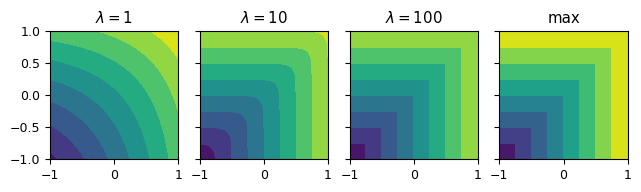

In [18]:
sigma1 = np.linspace(-1, 1, 100)
sigma2 = np.linspace(-1, 1, 100)
s1, s2 = np.meshgrid(sigma1, sigma2)

fig, axs = plt.subplots(1, 4, figsize=(16 / 2.54, 6 / 2.54), sharey=True)

for ax, lambd in zip(axs, (1, 10, 100)):
    ax.set_title(rf"$\lambda = {lambd}$")
    ax.contourf(s1, s2, lse([s1, s2], lambd))

axs[3].set_title("max")
axs[3].contourf(s1, s2, np.max([s1, s2], axis=0))

for ax in axs:
    ax.set_aspect("equal")

The $\mathrm{lse}$ function converges to the $\max$ function with increasing $\lambda$.

### (c)

In [23]:
def softargmax(sigma, lambd):
    sigma = np.asarray(sigma)
    return np.exp(lambd * sigma) / np.exp(lambd * sigma).sum(axis=0)

def onehot(sigma):
    sigma = np.asarray(sigma)
    return np.argmax(sigma, axis=0)

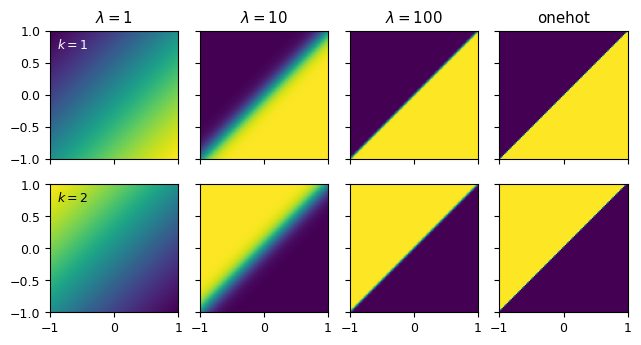

In [53]:
fig, axs = plt.subplots(2, 4, figsize=(16 / 2.54, 8.5 / 2.54), sharex=True, sharey=True)

for col, lambd in zip(axs.T, (1, 10, 100)):
    ax1, ax2 = col
    ax1.set_title(rf"$\lambda = {lambd}$")
    ax1.imshow(softargmax([s1, s2], lambd)[0], origin="lower", extent=[-1, 1, -1, 1])
    ax2.imshow(softargmax([s1, s2], lambd)[1], origin="lower", extent=[-1, 1, -1, 1])

    if lambd == 1:
        ax1.text(0.05, 0.95, "$k=1$", va="top", transform=ax1.transAxes, c="w")
        ax2.text(0.05, 0.95, "$k=2$", va="top", transform=ax2.transAxes)

axs.T[3][0].set_title("onehot")
axs.T[3][0].imshow(onehot([s2, s1]), origin="lower", extent=[-1, 1, -1, 1])
axs.T[3][1].imshow(onehot([s1, s2]), origin="lower", extent=[-1, 1, -1, 1])

for ax in axs.flatten():
    ax.set_aspect("equal")

### (d)

$$ \begin{aligned}
    \frac{\partial}{\partial \sigma_k} \left[\frac{1}{\lambda} \log\left(\sum_{j=1}^K \exp(\lambda \sigma_j)\right)\right]
    = \frac{1}{\lambda} \cdot \frac{\partial_k \sum_j \exp(\lambda \sigma_j)}{\sum_j \exp(\lambda \sigma_j)} = \frac{\exp(\lambda\sigma_k)}{\sum_j \exp(\lambda\sigma_j)}
\end{aligned} $$

## Linear regions of MLPs

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

### (a)

In [129]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(2, 20)
        self.output = nn.Linear(20, 1)

    def forward(self, x):
        x = self.hidden(x)
        x = F.relu(x)
        return self.output(x)

The step from the input to the hidden layer has $(2+1)\cdot20=60$ parameters, and the step from the hidden to the output layer has $(20 + 1)\cdot1=21$ parameters. The $+1$ come from the biases, so the total number of parameters is $81$.

### (b)

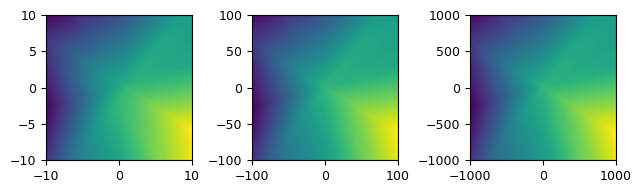

In [130]:
model = Model()

fig, axs = plt.subplots(1, 3, figsize=(16 / 2.54, 6 / 2.54))
ranges = [10, 100, 1000]

for ax, range in zip(axs, ranges):
    axis = np.linspace(-range, range, 500)
    grid = np.array(np.meshgrid(axis, axis))
    input = torch.from_numpy(grid.T).float()
    output = model(input).detach().numpy()

    ax.imshow(output, origin="lower", extent=[-range, range, -range, range])

It seems that the structure is already captured by the initial range, though it gets a little sharper when zooming out a bit.

### (c)

In [141]:
range = 20
axis = np.linspace(-range, range, 500)
grid = np.array(np.meshgrid(axis, axis))
input = torch.from_numpy(grid.T).float()
output = model(input).detach().numpy()

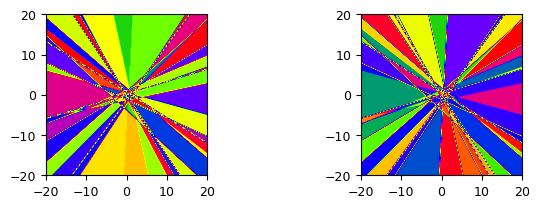

In [142]:
dx, dy = np.gradient(output.squeeze())

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16 / 2.54, 5 / 2.54))

ax1.imshow(dx, origin="lower", cmap="prism", extent=[-range, range, -range, range])
ax2.imshow(dy, origin="lower", cmap="prism", extent=[-range, range, -range, range])

plt.show()

We can see a lot of lines that intersect in a region close to the zero-point. Outside that region, these lines and the areas they make up mostly just go on forever, which confirms that the structure sits at the center. The lines are originating from the ReLU functions, whose derivatives are step functions. As the random biases assigned by pytorch are sampled between -1 and 1, that is also the region where many lines come together to form a structure.

### (d)

In [149]:
class DeeperModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(2, 5)
        self.hidden2 = nn.Linear(5, 5)
        self.hidden3 = nn.Linear(5, 5)
        self.hidden4 = nn.Linear(5, 5)
        self.output = nn.Linear(5, 1)

    def forward(self, x):
        x = self.hidden1(x)
        x = F.relu(x)
        x = self.hidden2(x)
        x = F.relu(x)
        x = self.hidden3(x)
        x = F.relu(x)
        x = self.hidden4(x)
        x = F.relu(x)
        return self.output(x)

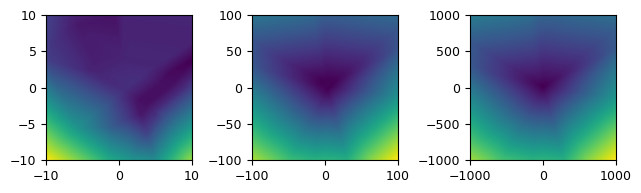

In [150]:
model = DeeperModel()

fig, axs = plt.subplots(1, 3, figsize=(16 / 2.54, 6 / 2.54))
ranges = [10, 100, 1000]

for ax, range in zip(axs, ranges):
    axis = np.linspace(-range, range, 500)
    grid = np.array(np.meshgrid(axis, axis))
    input = torch.from_numpy(grid.T).float()
    output = model(input).detach().numpy()

    ax.imshow(output, origin="lower", extent=[-range, range, -range, range])

Here we can definitely see that we need to zoom out a bit to capture the full structure (although 100 and 1000 is arguably a bit much).

In [159]:
range = 20
axis = np.linspace(-range, range, 500)
grid = np.array(np.meshgrid(axis, axis))
input = torch.from_numpy(grid.T).float()
output = model(input).detach().numpy()

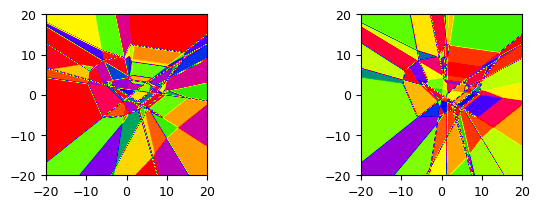

In [160]:
dx, dy = np.gradient(output.squeeze())

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16 / 2.54, 5 / 2.54))

ax1.imshow(dx, origin="lower", cmap="prism", extent=[-range, range, -range, range])
ax2.imshow(dy, origin="lower", cmap="prism", extent=[-range, range, -range, range])

plt.show()

When adding more layers, we are not constrained to lines anymore, so the step functions have boundaries in more complex shapes. With that, the structure in the center gets a larger and more complex.